# Simulated pendulum image data

This colab includeds three methods for simulating pendulum image data. The methods were taken and modified from recent publications and include Matplotlib and OpenAI gym approaches.





## Potential problems:

**Modeling**
- Build a deep latent variable model e.g. (AutoEncoder, Variational AutoEncoder) to predict images for the next $n$ timesteps.
- Build a deep latent variable model e.g. (AutoEncoder, Variational AutoEncoder) to discover the underlying system coordinates or coordinate like values from image data, Image => angle
- Build a deep latent variable model e.g. (AutoEncoder, VAE) to discover physical parameters or like values that describe the system e.g. (spring or dampening coefficient like values).
 
**Evaluation**
- Check model resilience with the addition of noise pixels or image distortions. 
- Check model generalizability through long term prediction accuracy outside of the training range. 

**Note:** Do not use the known ground truth coordinates or parameters from data generation in your loss function. Rather structure your model architecture to learn these in an unsupervised manner from the images. It might be helpful to think of your model's decoder as a function of its latent variables ($z$). <br>
$$decoder  => f(z_1,z_2,...,z_n) = \hat{y}$$ <br>
For example, if your goal is to predict the next position, a minimal latent representation might include velocity ($v$). To allow your model to learn velocity you can feed it two sequential images at a time. 
$$decoder  => f(v,z_2,...,z_n) = \hat{y}$$ <br>


## Suggested first steps:
**Data generation**
- Review pendulum and simple harmonic motion equations.
- Experiment with and modify the pendulum data simulation scripts. Add a damping or spring constant and note the effect on the simulation.

**Modeling**
- Build a AutoEncoder/VAE for mnist with a latent dimension size 10. Experiment with interpolating the latent space. 
  - General overview: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
  - Mnist latent space visualization: https://www.siarez.com/projects/variational-autoencoder#mnist_reconstruction
- Swap mnist for a pendulum dataset and try to reconstruct the pendulum images. Vary the latent vector size.


## Method 1: Matplotlib ball

$\ddot{z} = -sin(z)$ <br>
Where: <br>
$z = $ angle

Modified from:
- https://github.com/kpchamp/SindyAutoencoders

In [ ]:
import numpy as np
from scipy.integrate import odeint

In [ ]:
def get_pendulum_data(n_ics):
    t,x,dx,ddx,z = generate_pendulum_data(n_ics)
    data = {}
    data['t'] = t
    data['x'] = x.reshape((n_ics*t.size, -1))
    data['dx'] = dx.reshape((n_ics*t.size, -1))
    data['ddx'] = ddx.reshape((n_ics*t.size, -1))
    data['z'] = z.reshape((n_ics*t.size, -1))[:,0:1]
    data['dz'] = z.reshape((n_ics*t.size, -1))[:,1:2]

    return data


def generate_pendulum_data(n_ics):

    def f(z,t):
      return [z[1], -np.sin(z[0])]
      
    t = np.arange(0, 10, .02)

    z = np.zeros((n_ics,t.size,2))
    dz = np.zeros(z.shape)

    z1range = np.array([-np.pi,np.pi])
    z2range = np.array([-2.1,2.1])
    i = 0
    while (i < n_ics):
        z0 = np.array([(z1range[1]-z1range[0])*np.random.rand()+z1range[0],
            (z2range[1]-z2range[0])*np.random.rand()+z2range[0]])
        if np.abs(z0[1]**2/2. - np.cos(z0[0])) > .99:
            continue
        z[i] = odeint(f, z0, t)
        dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
        i += 1

    x,dx,ddx = pendulum_to_movie(z, dz)

    return t,x,dx,ddx,z


def pendulum_to_movie(z, dz):
    n_ics = z.shape[0]
    n_samples = z.shape[1]
    n = 51 # image dimension (51,51)
    y1,y2 = np.meshgrid(np.linspace(-1.5,1.5,n),np.linspace(1.5,-1.5,n))

    def create_image(theta):
      return np.exp(-((y1-np.cos(theta-np.pi/2))**2 + (y2-np.sin(theta-np.pi/2))**2)/.05)

    def argument_derivative(theta,dtheta):

      return -1/.05*(2*(y1 - np.cos(theta-np.pi/2))*np.sin(theta-np.pi/2)*dtheta \
             + 2*(y2 - np.sin(theta-np.pi/2))*(-np.cos(theta-np.pi/2))*dtheta)
      
    def argument_derivative2(theta,dtheta,ddtheta):
      return -2/.05*((np.sin(theta-np.pi/2))*np.sin(theta-np.pi/2)*dtheta**2 \
             + (y1 - np.cos(theta-np.pi/2))*np.sin(theta-np.pi/2)*ddtheta \
             + (-np.cos(theta-np.pi/2))*(-np.cos(theta-np.pi/2))*dtheta**2 \
             + (y2 - np.sin(theta-np.pi/2))*(np.sin(theta-np.pi/2))*dtheta**2 \
             + (y2 - np.sin(theta-np.pi/2))*(-np.cos(theta-np.pi/2))*ddtheta)

    x = np.zeros((n_ics, n_samples, n, n))
    dx = np.zeros((n_ics, n_samples, n, n))
    ddx = np.zeros((n_ics, n_samples, n, n))
    for i in range(n_ics):
        for j in range(n_samples):
            z[i,j,0] = wrap_to_pi(z[i,j,0])
            x[i,j] = create_image(z[i,j,0])
            dx[i,j] = (create_image(z[i,j,0])*argument_derivative(z[i,j,0], dz[i,j,0]))
            ddx[i,j] = create_image(z[i,j,0])*((argument_derivative(z[i,j,0], dz[i,j,0]))**2 \
                            + argument_derivative2(z[i,j,0], dz[i,j,0], dz[i,j,1]))
            
    return x,dx,ddx


def wrap_to_pi(z):
    z_mod = z % (2*np.pi)
    subtract_m = (z_mod > np.pi) * (-2*np.pi)
    return z_mod + subtract_m

### Generating data

In [ ]:
training_data = get_pendulum_data(1)

In [ ]:
training_data.keys()

dict_keys(['t', 'x', 'dx', 'ddx', 'z', 'dz'])

In [ ]:
training_data['x'].shape

(500, 2601)

### Visualizing data

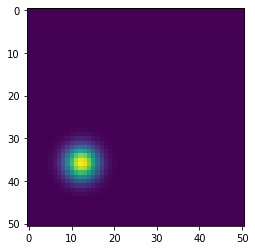

In [ ]:
import matplotlib.pyplot as plt

img_number = 75

plt.imshow(training_data['x'][img_number].reshape(51,51));

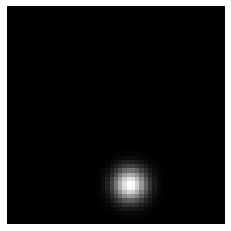

In [ ]:
# animating one trajectory
import matplotlib.animation as animation

fig = plt.figure()
frames = training_data['x'][:500]
im = plt.imshow(frames[0].reshape(51,51), cmap = 'gray')

plt.axis('off')

def animate(i):
    img = frames[i].reshape(51,51)

    return [im.set_array(img)]

anim = animation.FuncAnimation(
                               fig, 
                               animate,
                               frames = 500,
                               interval = 30
                               )

In [ ]:
from IPython.core.display import display, HTML
HTML(anim.to_html5_video())

In [ ]:
training_data['z'].shape

(500, 1)

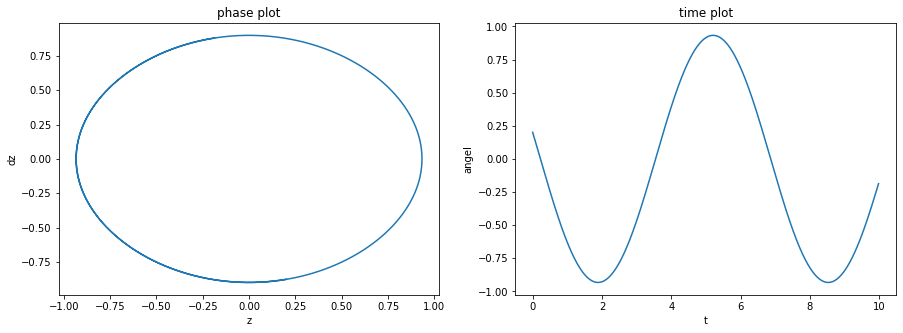

In [ ]:
n = 500 # number of points to plot, 500 in each trajectory
fig,(ax1, ax2) =  plt.subplots(1,2)
fig.set_size_inches(15, 5)
ax1.plot(training_data['z'][:n], training_data['dz'][:n]);
ax1.set_title('phase plot')
ax1.set_xlabel('z')
ax1.set_ylabel('dz')
ax2.plot(training_data['t'][:n], training_data['z'][:n]);
ax2.set_title('time plot')
ax2.set_xlabel('t')
ax2.set_ylabel('angel');

## Method 2: Matplotlib bar

$ \ddot{q}=  -b\dot{q} - \frac{g}{l}sin(q)$ <br>
Where: <br>
$g =$ gravity <br>
$l =$ length <br>
$b =$ damping

Modified from:
- https://github.com/steindoringi/Variational_Integrator_Networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

class System(object):

    def __init__(self, observations, seed, **kwargs):

        self.observations = observations
        self.RNG = np.random.RandomState(seed)
        self.system_param = kwargs
        self._init_system(**kwargs)

    def _init_system(self, **kwargs):
        raise NotImplementedError()

    def _random_init_state(self):
        raise NotImplementedError()

    def _ODE(self, t, y):
        raise NotImplementedError()

    def _state_to_observations(self, qqdot):
        if self.observations == "observed":
            return qqdot
        elif self.observations == "noisy":
            noise = self.RNG.randn(*qqdot.shape) * self.system_param["noise_std"]
            return qqdot + noise
        elif self.observations == "pixels":
            return self._state_to_pixels(qqdot)

    def _state_to_pixels(self, qqdot):
        raise NotImplementedError()

    def compute_energy(self, qqdot):
        raise NotImplementedError()

    def integrate_ODE(self, num_steps, step_size, y0=None, rtol=1e-12):

        T = num_steps * step_size
        t = np.linspace(0.0, T, num_steps)

        if y0 is None:
            y0 = self._random_init_state()

        solver = ode(self._ODE).set_integrator('dop853', rtol=rtol) # 4th RK = 'dopri5'
        sol = np.empty((len(t), 2))
        sol[0] = y0
        solver.set_initial_value(y0)
        k = 1
        while solver.successful() and solver.t < T:
            solver.integrate(t[k])
            sol[k] = solver.y
            k += 1
        
        return sol

    def run(self, num_traj, num_steps, step_size, y0=None):

        qqd = []
        for n in range(num_traj):
            if y0 is not None:
                y0_n = y0[n]
            else:
                y0_n = None
            qqd_n = self.integrate_ODE(num_steps, step_size, y0=y0_n)
            qqd.append(qqd_n[None])
        qqd = np.vstack(qqd)

        return self._state_to_observations(qqd), qqd

class Pendulum(System):

    def _init_system(self, mass=1.0, length=1.0, g=9.82, friction=0., **kwargs):

        def pendulum_ODE(t, y):
            q, qdot = y
            dydt = [qdot, -friction*qdot - (g/length)*np.sin(q)]
            return dydt

        self._ODE = pendulum_ODE

    def _random_init_state(self):

        sign = [-1., 1.]
        q0 = np.pi - self.RNG.uniform(low=0.1, high=1./2.*np.pi)
        q0 = self.RNG.choice(sign)*q0
        qdot0 = self.RNG.uniform(low=-1., high=1.)
        y0 = np.hstack([q0, qdot0])
        return y0

    def _state_to_pixels(self, qqdot):

        length = self.system_param["length"]
        q, qdot = np.split(qqdot, 2, axis=-1)
        x = length * np.sin(q)
        y = -length * np.cos(q)

        f, ax = plt.subplots(figsize=(1, 1), dpi=28)
        f_lim = length + 0.5

        ys = []
        for traj in range(q.shape[0]):
            y_traj = []
            for t in range(q.shape[1]):
                plt.cla()
                ax.set_xlim(-f_lim, f_lim)
                ax.set_ylim(-f_lim, f_lim)
                ax.plot([0, x[traj, t]],[0, y[traj, t]], linewidth=12, color="black")
                ax.axis('off')
                f.canvas.draw()
                y_t = np.array(f.canvas.renderer.buffer_rgba())[:, :, :1]
                y_t[y_t > 0] = 255
                y_t[y_t == 0] = 1.
                y_t[y_t == 255] = 0.
                y_traj.append(np.float32(y_t[None]))
            y_traj = np.vstack(y_traj)
            ys.append(y_traj[None])
        ys = np.vstack(ys)
        ys = ys.reshape(*ys.shape[:2], 784)

        return ys

### Generating data

In [ ]:
pen_params = dict(mass = 1.0, 
                  length = 1.0, 
                  g = 9.82, 
                  friction = 0)

In [ ]:
# create system
observations =  'pixels'
seed =   1 

system = Pendulum(observations, seed, **pen_params)

obs, states = system.run(num_traj = 1, num_steps = 402, step_size = 0.1)

In [ ]:
obs.shape # images 28 x 28 = 784

(1, 402, 784)

In [ ]:
states.shape # x, x_dot

(1, 402, 2)

### Visualizing data

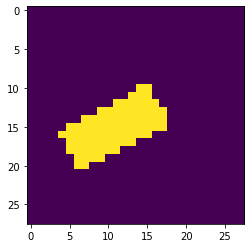

In [ ]:
plt.imshow(obs.squeeze()[25].reshape(28,28));

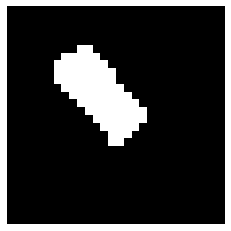

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
frames = obs[0]
im = plt.imshow(frames[0].reshape(28,28), cmap = 'gray')

plt.axis('off')

def animate(i):
    img = frames[i].reshape(28,28)

    return [im.set_array(img)]

anim = animation.FuncAnimation(
                               fig, 
                               animate,
                               frames = 400,
                               interval = 99
                               )

In [ ]:
from IPython.core.display import display, HTML
HTML(anim.to_html5_video())

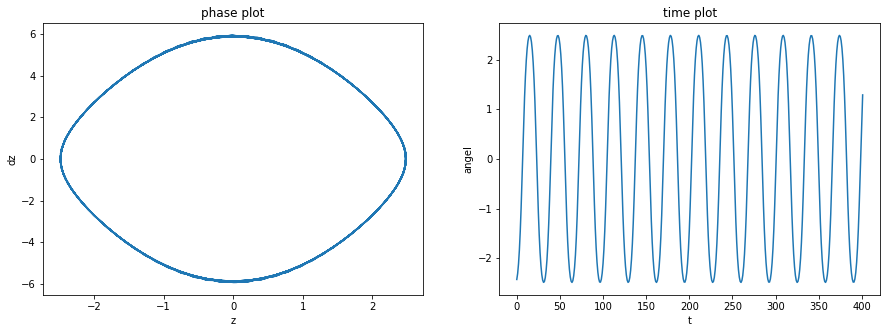

In [ ]:
fig,(ax1, ax2) =  plt.subplots(1,2)
fig.set_size_inches(15, 5)
ax1.plot(states[0][:,0],states[0][:,1]);
ax1.set_title('phase plot')
ax1.set_xlabel('z')
ax1.set_ylabel('dz')
ax2.plot(states[0][:,0]);
ax2.set_title('time plot')
ax2.set_xlabel('t')
ax2.set_ylabel('angel');

## Method 3: OpenAI gym

Modified from: 
- https://github.com/greydanus/hamiltonian-nn

OpenAI's pendulum gym environment:
- https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

In [ ]:
# configuring env for OpenAI gym in colab
!apt-get install python-opengl -y
!apt install xvfb -y

!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (748 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The 

In [ ]:
#data gen
import numpy as np
import gym
import os, sys
import pickle
import io
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageSequence, ImageFont
import imageio

#Eval
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

In [ ]:
def get_theta(obs):
    '''Transforms coordinate basis from the defaults of the gym pendulum env.'''
    theta = np.arctan2(obs[0], -obs[1])
    theta = theta + np.pi/2
    theta = theta + 2*np.pi if theta < -np.pi else theta
    theta = theta - 2*np.pi if theta > np.pi else theta
    return theta
    
def preproc(X, side):
    '''Crops, downsamples, desaturates, etc. the rgb pendulum observation.'''
    X = X[...,0][220:400,125:375] - X[...,1][220:400,125:375]

    return np.array(Image.fromarray(X).resize((int(side),side)))/255 # depricated: scipy.misc.imresize(X, [int(side), side]) / 255.

def gen_gym_data(n_points):

  gym_settings = locals()

  env = gym.make(pen_params['env_name'])
  env.reset()
  env.seed(pen_params['seed'])

  angle_check = True

  canonical_coords, frames = [], []

  for step in range(n_points + 2):
    while angle_check == True:
      obs = env.reset()
      theta_init = np.abs(get_theta(obs))

      if theta_init > pen_params['min_angle'] and theta_init < pen_params['max_angle']:
          angle_check = False
        

    frames.append(preproc(env.render('rgb_array'), pen_params['side']))

    obs, _, _, _ = env.step([0.])
    theta, dtheta = get_theta(obs), obs[-1]

    # The constant factor of 0.25 comes from saying plotting H = PE + KE*c
    # and choosing c such that total energy is as close to constant as
    # possible. It's not perfect, but the best we can do.
    canonical_coords.append( np.array([theta, 0.25 * dtheta]) )

  canonical_coords = np.stack(canonical_coords)
  frames = np.stack(frames)

  cc = canonical_coords[1:]
  dcc = cc[1:] - cc[:-1]
  cc = cc[1:]

  frames[1:-1]

  return cc, dcc, frames

### Generating data

In [ ]:
pen_params = {'seed': 0, 
              'side': 28, 
              'min_angle': 0., 
              'max_angle': np.pi/6, 
              'env_name': 'Pendulum-v0'}

In [ ]:
canonical_coords, dot_cc, frames = gen_gym_data(n_points = 400)

### Visualizing data

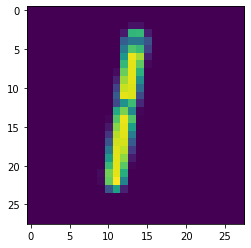

In [ ]:
plt.imshow(frames[90])

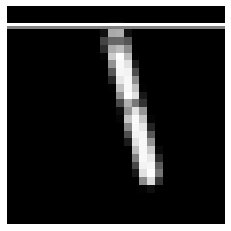

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
im = plt.imshow(frames[0].reshape(28,28), cmap = 'gray')
plt.axhline(y = 2.1, linewidth=3, color='gray')
plt.axhline(y = 1.8, linewidth=3, color='white')
plt.axis('off')

def animate(i):
    img = frames[i].reshape(28,28)

    return [im.set_array(img)]

anim = animation.FuncAnimation(
                               fig, 
                               animate,
                               frames = 100,
                               interval = 99
                               )

In [ ]:
from IPython.core.display import display, HTML
HTML(anim.to_html5_video())

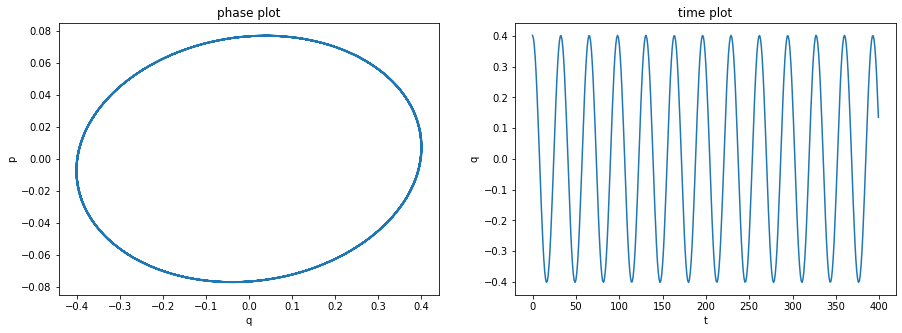

In [ ]:
fig,(ax1, ax2) =  plt.subplots(1,2)
fig.set_size_inches(15, 5)
ax1.plot(canonical_coords[:,0],dot_cc[:,0]);
ax1.set_title('phase plot')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax2.plot(canonical_coords[:,0]);
ax2.set_title('time plot')
ax2.set_xlabel('t')
ax2.set_ylabel('q');